# SV with Particle filter (WIP) - free params and proposal, jointly optimized

In [4]:
import matplotlib.pyplot as plt
import torch

import ptvi

In [1]:
data_seed, algo_seed = 123, 123
params = dict(a=1., b=0., c=.95)
T = 200

In [6]:
model = ptvi.FilteredStochasticVolatilityModelFreeProposal(
    input_length=T, num_particles=30, resample=True)
model

Stochastic volatility model:
	x_t = exp(a * z_t/2) ε_t      t=1, …, 200
	z_t = b + c * z_{t-1} + ν_t,  t=2, …, 200
	z_1 = b + 1/√(1 - c^2) ν_1
	where ε_t, ν_t ~ Ν(0,1)

Particle filter with 30 particles, AR(1) proposal:
	z_t = d + e * z_{t-1} + η_t,  t=2, …, 200
	z_1 = d + 1/√(1 - e^2) η_1
	where η_t ~ Ν(0,1)

In [7]:
torch.manual_seed(data_seed)
y, z_true = model.simulate(**params)

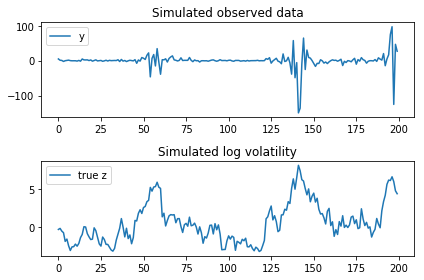

In [8]:
plt.subplot(211); plt.plot(y.numpy(), label='y')
plt.title('Simulated observed data')
plt.legend();
plt.subplot(212); plt.plot(z_true.numpy(), label='true z')
plt.legend()
plt.title('Simulated log volatility');
plt.tight_layout()

In [10]:
torch.manual_seed(algo_seed)
fit = sgvb(model, y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured ADVI: Particle filtered stochastic volatility model
  - Estimating elbo with M=1;
  - Minimum supremum growth heuristic (min_steps=500, patience=20, skip=10, ε=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo =-1482.88
       1. smoothed elbo =-1413.64
       2. smoothed elbo =-1342.02
       4. smoothed elbo =-1278.22
       8. smoothed elbo =-1248.80
      16. smoothed elbo =-1877.49
      32. smoothed elbo =-1503.86
      64. smoothed elbo =-1926.05
     128. smoothed elbo =-1182.83
     256. smoothed elbo =-2587.40
     512. smoothed elbo =-37743.04


RuntimeError: invalid argument 2: invalid multinomial distribution (encountering probability entry < 0) at /pytorch/aten/src/TH/generic/THTensorRandom.cpp:407

In [ ]:
fit.plot_elbos()

In [ ]:
fit.summary(true=params)

In [ ]:
fit.plot_global_marginals(**params)

In [ ]:
fit.plot_latent(N=50, true_z=z_true)

In [ ]:
fit.plot_pred_ci(N=50, α=.1, true_y=y, fc_steps=20)